In [3]:
%load_ext autoreload

In [4]:
autoreload 2

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import sympy as sym

import inputs
import models
import shooting

from __future__ import division

### Welcome to the Estimation notebook!

This notebook defines some workers and firms - usign parameters obtained from Distributions.ipynb - solves for a first run of the model and then uses the estimation code to get the sum of squared residuals between data (taken from PD05_wage.csv) and the implied functions of the model: mu(x), theta(x), w(x)

In [7]:
# define some default workers skill
x, mu1, sigma1 = sym.var('x, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'mu1': 3.8894753094349528, 'sigma1': 0.63718247398434291}
skill_bounds = [0.01, 340.6127]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some default firms
y, mu2, sigma2 = sym.var('y, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'mu2': 7.13768801209, 'sigma2': 1.92573671813}
productivity_bounds = [1.93, 1151284.0]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for Cobb-Douglas between l and r
l, r, omega_B, sigma_B = sym.var('l, r, omega_B, sigma_B')
B = l**omega_B * r**(1 - omega_B)

F = A * B

F_params = {'omega_A':0.75, 'omega_B':0.75, 'sigma_A':0.6, 'sigma_B':1.0}

model = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = shooting.ShootingSolver(model=model)

** Now that everything is defined, let's try to solve the model once first! **

This will give us a good idea about inital guesses and number of knots.

In [8]:
solver.solve(20000, tol=1e-6, number_knots=6000, atol=1e-15, rtol=1e-12, integrator='vode', message=False)

Success! All workers and firms are matched


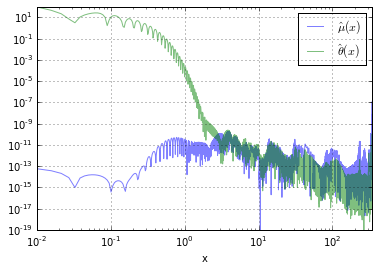

In [9]:
solver.residuals.plot(loglog=True, alpha=0.5)
plt.show()

** This bit imports the estimation_code and solves it for some parameters (same as above) **

In [15]:
import estimation_code_1 as est

In [14]:
ps = (0.75, 0.75, 0.6)

xs, ys, thetas, ws = est.import_data('PD05_wage.csv')

skill_p = (3.8894753094349528, 0.63718247398434291)
skill_b = [0.01, 340.6127]

firm_p = (7.13768801209, 1.92573671813)
firm_b = [1.93, 1151284.0]

est.ObjectiveFunction(ps, (xs, ys, thetas, ws), skill_p, skill_b, firm_p, firm_b, 500.0)

Success! All workers and firms are matched


[1494915370.1276474,
 23237562.02865909,
 279956.26883957192,
 33851099.918364525,
 33851099.918364525,
 33851099.918364525,
 349350.66882428533,
 349350.66882428533,
 1884662.2072821134,
 787.86531058439198,
 1627844.255396381,
 213846.54579585645,
 3138104.5466766553,
 3138104.5466766553,
 3138104.5466766553,
 3138104.5466766553,
 3138104.5466766553,
 2951760.8775650728,
 66978002.306050733,
 533828.1613957556,
 48155764.370406382,
 78616.000801592454,
 56542.599411565345,
 1435369.1814867689,
 2941704.9850425581,
 2941704.9850425581,
 20232624.17582985,
 1936467.0632600281,
 2307570.4400274144,
 869.23928323945609,
 869.23928323945609,
 1620705.8622918569,
 1620705.8622918569,
 1620705.8622918569,
 1620705.8622918569,
 1620705.8622918569,
 1620705.8622918569,
 1620705.8622918569,
 448992.38239187532,
 448992.38239187532,
 6369550.9869678812,
 2033900.7948897295,
 152154.6052337084,
 152154.6052337084,
 24285863.462971523,
 9364205.5136342403,
 9364205.5136342403,
 9364205.5136342403

** You can try the two function individually: **

In [20]:
mu_hat, theta_hat, w_hat = est.Solve_Model(F, F_params, workers, firms, 'positive', 6000.0, 'vode', 500.0)

Success! All workers and firms are matched


In [21]:
est.Calculate_MSE( (xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat) )

(376593323.27147698, 273425.14310789062, 120067.97551893492)

## Iterate for some parameters

In [31]:
om = 0.65
h_theta = 400.0
results_i = []
for i in range(7):
    om -= 0.05
    params_i = {'omega_A':0.75, 'omega_B':0.25, 'sigma_A':om, 'sigma_B':1.0}
    (mu_hat, theta_hat, w_hat), h_theta = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'vode', h_theta)
    results_i.append(est.Calculate_MSE( (xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat) ))

results_i

AssertionError: Upper and lower bounds are identical: check solver tols!

In [ ]:
    else:
        params_i = {'omega_A':0.75, 'omega_B':0.25, 'sigma_A':om, 'sigma_B':1.0}
        Est_Dis = solve_model.Solve_Model(F, params_i, workers, firms, 'positive', 100, 'vode', 2e4)
        model_param = (Est_Dis[0], Est_Dis[1])
        results_i.append(solve_model.Calculate_MSE_pdf(data_points, data_param, model_param, 'lognormal'))

In [16]:
solver.solution

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
0.010000,1.929999,393.154013,0.002555,0.334811
0.066777,1.929999,32.858541,0.030568,0.334811
0.123553,1.929999,14.971686,0.067089,0.334811
0.180330,1.929999,9.307638,0.107915,0.334811
0.237106,1.929999,6.628808,0.151526,0.334811
0.293883,1.929999,5.096116,0.197098,0.334811
0.350659,1.929999,4.114611,0.244114,0.334811
0.407436,1.929999,3.437276,0.292218,0.334811
0.464213,1.929999,2.944238,0.341153,0.334811


In [25]:
xs = solver.solution.index.values
rmus = solver.solution['$\\mu(x)$'].values
rthetas = solver.solution['$\\theta(x)$'].values
rws = solver.solution['$w(x)$'].values

In [28]:
xs[-1]

340.61270000000002